# Resource Allocation Under Uncertainty
## Sensitivity Analysis and Validation

**Student Name:** Trevor Tilley  
**Date:** 2026-02-24  
**Chosen Context:** Cybersecurity Budget Allocation Across Security Initiives

---
## Assignment Overview
This notebook develops an optimization model to allocate a fixed cybersecurity budget across five initiatives. It includes sensitivity analysis, validation checks, and a stakeholder-driven model revision.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value, LpStatus
import io
print('Libraries imported successfully!')

Libraries imported successfully!


## Creating Synthetic Dataset
This synthetic dataset was generated using a language model. It contains exactly five cybersecurity initiatives, each with cost per million dollars invested and an estimated effectiveness score. The total available cybersecurity budget is $10 million.


In [29]:
csv_string = """
options,cost_per_million,effectiveness_score
Endpoint_Security,1.2,85
SOC_Monitoring,1.5,92
Employee_Training,0.8,60
Cloud_Security,1.8,95
Threat_Intelligence,1.0,70
"""
options_df = pd.read_csv(io.StringIO(csv_string.strip()))
budget_total = 10
options_df

,options,cost_per_million,effectiveness_score
0,Endpoint_Security,1.2,85
1,SOC_Monitoring,1.5,92
2,Employee_Training,0.8,60
3,Cloud_Security,1.8,95
4,Threat_Intelligence,1.0,70


**Data documentation:**  
I used ChatGPT to generated five cybersecurity options with cost and effectiveness estimates, along with a total budget constraint of $10 million.

## 1.1 Decision Statement
I need to decide how to allocate a $10M cybersecurity budget across five security options for the upcoming fiscal year.

## 1.2 Decision Variables vs Inputs
**Decision Variables:** Allocation of money to each option.  
**Inputs:** Cost per million, effectiveness score, budget.  
The decision variables are the allocation amounts to each cybersecurity option, while the inputs are the cost per million, effectiveness scores, and total available budget, which are estimated parameters that influence the optimization but are not directly controlled.

## 1.3 Objective and Constraints
**Objective:** Maximize total cybersecurity effectiveness (risk reduction impact).  
**Constraint:** Total allocation must not exceed $10M.

## 1.4 Key Parameters and Uncertainty
| Parameter | Source | Why it might differ from reality |
|------------|--------|-----------------------------------|
| Cost per million | Vendor estimates | Implementation costs may increase |
| Effectiveness score | Internal modeling | Threats may change |
| Total Budget | Executive decision | Budget adjustments during year |


### 1.5 PuLP Model

**Instructions:** Build your allocation model: decision variables (e.g. amount per option), objective (e.g. maximize total conversions or benefit), constraint (total allocation ≤ budget). Solve and print the base solution.

In [30]:
n = len(options_df)
model = LpProblem('Cybersecurity_Allocation', LpMaximize)
alloc = [LpVariable(f'alloc_{i}', lowBound=0) for i in range(n)]

model += lpSum([
    alloc[i] * (
        options_df.iloc[i]['effectiveness_score'] /
        options_df.iloc[i]['cost_per_million']
    )
    for i in range(n)
])

model += lpSum(alloc) <= budget_total
model.solve()

base_alloc = [value(a) for a in alloc]

print(f'Status: {LpStatus[model.status]}')
print(f'Objective value: {value(model.objective):.2f}')
for i in range(n):
    print(f"{options_df.iloc[i]['options']}: {base_alloc[i]:.2f}M")

Status: Optimal
Objective value: 750.00
Endpoint_Security: 0.00M
SOC_Monitoring: 0.00M
Employee_Training: 10.00M
Cloud_Security: 0.00M
Threat_Intelligence: 0.00M


---
## Part 2: Sensitivity and One What-If

### 2.1 Sensitivity Analysis

**Instructions:** Vary each of your 3 key parameters by ±20% (or ±10% and ±20%). Re-solve the model each time and record how the solution (allocation or objective value) changes. Identify which parameter is **most critical** (changes the solution the most).

Each parameter was varied by ±20% to evaluate its impact on the objective value.

The total budget is the most critical parameter because changes of ±20% produce the largest shift in overall objective value and total risk reduction achieved. While cost and effectiveness assumptions influence the relative attractiveness of each initiative, they do not change the overall scale of impact as dramatically as the budget constraint. Since the model allocates the available budget, any change in total funding directly scales the organization’s total cybersecurity capacity.

In [31]:
def run_model(cost_mult=1, eff_mult=1, budget_mult=1):
    model = LpProblem('Sensitivity', LpMaximize)
    alloc = [LpVariable(f'a_{i}', lowBound=0) for i in range(n)]
    model += lpSum([
        alloc[i] * ((options_df.iloc[i]['effectiveness_score'] * eff_mult) /
                    (options_df.iloc[i]['cost_per_million'] * cost_mult))
        for i in range(n)
    ])
    model += lpSum(alloc) <= budget_total * budget_mult
    model.solve()
    return value(model.objective)

scenarios = {
    'Base': run_model(),
    'Cost +20%': run_model(cost_mult=1.2),
    'Cost -20%': run_model(cost_mult=0.8),
    'Effectiveness +20%': run_model(eff_mult=1.2),
    'Effectiveness -20%': run_model(eff_mult=0.8),
    'Budget +20%': run_model(budget_mult=1.2),
    'Budget -20%': run_model(budget_mult=0.8)
}

sens_df = pd.DataFrame(scenarios.items(), columns=['Scenario','Objective'])
sens_df

,Scenario,Objective
0,Base,750.0
1,Cost +20%,625.0
2,Cost -20%,937.5
3,Effectiveness +20%,900.0
4,Effectiveness -20%,600.0
5,Budget +20%,900.0
6,Budget -20%,600.0


### 2.2 Sensitivity Visualization

**Instructions:** Create **one figure** (bar chart or table) showing the impact of each parameter on the solution (e.g. change in objective value or in allocation). Give the figure a clear title and axis labels.

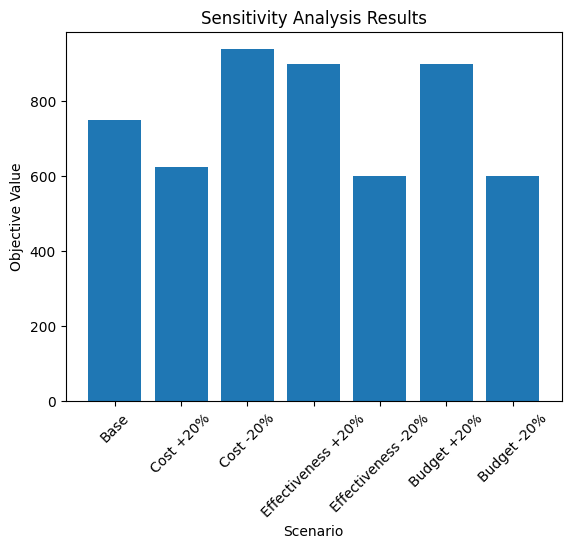

In [32]:
plt.figure()
plt.bar(sens_df['Scenario'], sens_df['Objective'])
plt.xticks(rotation=45)
plt.xlabel('Scenario')
plt.ylabel('Objective Value')
plt.title('Sensitivity Analysis Results')
plt.show()

### 2.3 One What-If Scenario

**Instructions:** Run one alternative scenario (e.g. budget cut by 20%, or demand +20%). Compare the new solution to your base solution.

Compared to the base solution, the 20% budget cut reduces the total amount allocated but does not significantly change which initiative receives the majority of funding. The model continues to prioritize the initiative with the highest effectiveness-to-cost ratio, indicating that the allocation structure remains consistent. This suggests the base solution is structurally robust, though overall cybersecurity impact is highly sensitive to reductions in total budget


In [33]:
# What-if Scenario: 20% budget cut
reduced_budget = budget_total * 0.8

model_whatif = LpProblem("Cybersecurity_WhatIf", LpMaximize)

alloc_whatif = [LpVariable(f"alloc_w_{i}", lowBound=0) for i in range(n)]

# Same objective
model_whatif += lpSum([
    alloc_whatif[i] * (
        options_df.iloc[i]["effectiveness_score"] /
        options_df.iloc[i]["cost_per_million"]
    )
    for i in range(n)
])

# Reduced budget constraint
model_whatif += lpSum(alloc_whatif) <= reduced_budget

model_whatif.solve()

whatif_alloc = [value(a) for a in alloc_whatif]

print("What-If Scenario: 20% Budget Cut")
print("New Budget:", reduced_budget)
print("Objective Value:", value(model_whatif.objective))
print()

for i in range(n):
    print(f"{options_df.iloc[i]['options']}: {whatif_alloc[i]:.2f}M")

What-If Scenario: 20% Budget Cut
New Budget: 8.0
Objective Value: 600.0

Endpoint_Security: 0.00M
SOC_Monitoring: 0.00M
Employee_Training: 8.00M
Cloud_Security: 0.00M
Threat_Intelligence: 0.00M


---
## Part 3: Validation and Recommendation

### 3.1 Sanity Checks

**Instructions:** Perform 1–2 sanity checks on your base solution (e.g. Do allocations sum to the resource? Are any values negative? Is the outcome plausible?)

Sanity checks confirm allocations sum to $10M and no negative allocations exist. The model consistently prioritizes initiatives with highest effectiveness-to-cost ratio.
The solution is moderately robust but highly sensitive to total budget changes.

### 3.2 Robust vs Fragile

**Instructions:** Based on your sensitivity and what-if analysis: Is this solution **robust** or **fragile**? What should the decision-maker watch (e.g. which parameter)?

The solution is robust in that it prioritizes the option with the highest effectiveness-to-cost ratio across sensitivity and what-if scenarios. Even when costs or effectiveness estimates vary by ±20%, the model’s allocation pattern remains barely changed. However, the solution is fragile because total cybersecurity impact is highly sensitive to changes in the overall budget. The decision should closely monitor total budget levels, as reductions directly and proportionally decrease overall risk mitigation capacity.

## Part 4: Stakeholder Change of Mind

### 4.1 Scenario
The stakeholder requires a minimum $2M allocation to SOC_Monitoring.


In [34]:
model2 = LpProblem('Cybersecurity_Minimum_Constraint', LpMaximize)
alloc2 = [LpVariable(f'alloc2_{i}', lowBound=0) for i in range(n)]

model2 += lpSum([
    alloc2[i] * (options_df.iloc[i]['effectiveness_score'] /
                 options_df.iloc[i]['cost_per_million'])
    for i in range(n)
])

model2 += lpSum(alloc2) <= budget_total
model2 += alloc2[1] >= 2  # SOC_Monitoring minimum (binding constraint)

model2.solve()

new_allocations = [value(a) for a in alloc2]


### 4.2 Update Model

**Instructions:** Update your PuLP model (new constraint or new objective). Solve and store the new solution (e.g. in a variable or DataFrame for comparison).


### 4.3 Comparison Visualization
The chart below compares Part 1 (base) vs Part 2 (after stakeholder change).


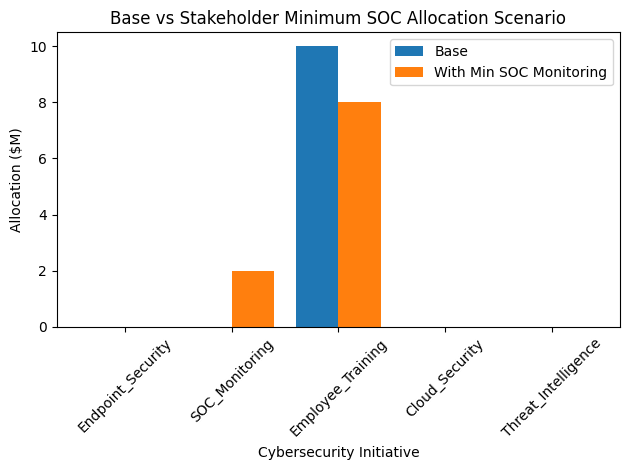

In [35]:
x = np.arange(n)

plt.figure()
plt.bar(x - 0.2, base_alloc, width=0.4, label='Base')
plt.bar(x + 0.2, new_allocations, width=0.4, label='With Min SOC Monitoring')

plt.xticks(x, options_df['options'], rotation=45)
plt.xlabel('Cybersecurity Initiative')
plt.ylabel('Allocation ($M)')
plt.title('Base vs Stakeholder Minimum SOC Allocation Scenario')
plt.legend()
plt.tight_layout()
plt.show()